In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import json

In [2]:
data = pd.read_csv('/home/ubuntu/jonathan/files_list.csv')
data.head()

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,0_Sideburns,0_Smiling,0_Straight_Hair,0_Wavy_Hair,0_Wearing_Earrings,0_Wearing_Hat,0_Wearing_Lipstick,0_Wearing_Necklace,0_Wearing_Necktie,0_Young
0,0,face_att_000007.jpg,face_att_000001.jpg,face_att_000001.jpg,face_att_000002.jpg,face_att_000051.jpg,face_att_000009.jpg,face_att_000003.jpg,face_att_000002.jpg,face_att_000007.jpg,...,face_att_000001.jpg,face_att_000003.jpg,face_att_000002.jpg,face_att_000001.jpg,face_att_000002.jpg,face_att_000001.jpg,face_att_000002.jpg,face_att_000001.jpg,face_att_000001.jpg,face_att_000015.jpg
1,1,face_att_000008.jpg,face_att_000005.jpg,face_att_000004.jpg,face_att_000007.jpg,face_att_000079.jpg,face_att_000029.jpg,face_att_000005.jpg,face_att_000007.jpg,face_att_000008.jpg,...,face_att_000002.jpg,face_att_000004.jpg,face_att_000003.jpg,face_att_000002.jpg,face_att_000003.jpg,face_att_000002.jpg,face_att_000003.jpg,face_att_000002.jpg,face_att_000002.jpg,face_att_000018.jpg
2,2,face_att_000015.jpg,face_att_000006.jpg,face_att_000005.jpg,face_att_000008.jpg,face_att_000115.jpg,face_att_000046.jpg,face_att_000006.jpg,face_att_000014.jpg,face_att_000011.jpg,...,face_att_000003.jpg,face_att_000005.jpg,face_att_000005.jpg,face_att_000004.jpg,face_att_000005.jpg,face_att_000003.jpg,face_att_000007.jpg,face_att_000003.jpg,face_att_000003.jpg,face_att_000021.jpg
3,3,face_att_000016.jpg,face_att_000008.jpg,face_att_000006.jpg,face_att_000012.jpg,face_att_000125.jpg,face_att_000048.jpg,face_att_000007.jpg,face_att_000015.jpg,face_att_000012.jpg,...,face_att_000004.jpg,face_att_000006.jpg,face_att_000006.jpg,face_att_000005.jpg,face_att_000007.jpg,face_att_000004.jpg,face_att_000008.jpg,face_att_000005.jpg,face_att_000004.jpg,face_att_000030.jpg
4,4,face_att_000023.jpg,face_att_000009.jpg,face_att_000007.jpg,face_att_000015.jpg,face_att_000134.jpg,face_att_000053.jpg,face_att_000008.jpg,face_att_000018.jpg,face_att_000014.jpg,...,face_att_000005.jpg,face_att_000007.jpg,face_att_000008.jpg,face_att_000007.jpg,face_att_000008.jpg,face_att_000005.jpg,face_att_000011.jpg,face_att_000006.jpg,face_att_000005.jpg,face_att_000032.jpg


In [3]:
nb_data = 4500 
# dict_color= {'Brown_Hair':1, 'Blond_Hair':2, 'Black_Hair':3, 'Bald':4, 'Gray_Hair':5}

def data_preprocess_multi(index_file, label, nb_data):
# for color in list(dict_color.keys()):
    df = pd.read_csv(index_file, usecols=[label])
    df_label = df[(df[label] != 0) & (df[label] != '0')][:nb_data]
    train_size = int(len(df_label) * 0.8)
    
    train = df_label[:train_size]    
    labels_train = [label]*train_size
    train = pd.DataFrame(
                {'files': train.iloc[:, 0], 'label': labels_train})

    test = df_label[train_size:nb_data]
    labels_test = [label]*(nb_data - train_size)
    test = pd.DataFrame(
                {'files': test.iloc[:, 0], 'label': labels_test})
    return train, test

In [4]:
index_file = '/home/ubuntu/jonathan/files_list.csv'
def create_dataframe_multi(index_file, label_list, nb_data):
    test_list =[]
    train_list = []
    for element in label_list: 
        train_name = 'train_' + element
        test_name = 'test_' + element
        train_name, test_name = data_preprocess_multi(index_file, element , nb_data)
        test_list.append(test_name)
        train_list.append(train_name)
    train = pd.concat(train_list, axis=0).drop_duplicates(subset=['files'])
    test = pd.concat(test_list, axis=0).drop_duplicates(subset=['files'])
    
    try:
        assert test['files'].nunique() == len(test)
        assert train['files'].nunique() == len(train)
        print("Assertions Passed! Sets  Are of image files W/O Duplication")
    except AssertionError:
        print("Assertions Failed")
        
    train = shuffle(train)
    test = shuffle(test)
    
    return train, test

In [5]:
index_file = '/home/ubuntu/jonathan/files_list.csv'
train, test = create_dataframe_multi(index_file, ['Brown_Hair','Blond_Hair', 'Black_Hair','Bald', 'Gray_Hair'], 4500)


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types. Specify dtype option on im

Assertions Passed! Sets  Are of image files W/O Duplication


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
imagepath = '/home/ubuntu/sheryl/face_att_sheryl'
def generator_splitter_multi(train, test, imagepath):
    """
    function uses the `ImageDataGenerator` class
    # load our dataset as an iterator (not keeping it all in memory at once).
    :param train:
    :param test:
    :param imagepath:
    :return: data split for train val and test
    """
    # Train Set
    # tf.config.list_physical_devices()
    train['label'] = train['label'].astype(str)
    img_gen = ImageDataGenerator(validation_split=0.2)

    train_data = img_gen.flow_from_dataframe(train,
                                             directory=imagepath,
                                             x_col='files',
                                             y_col='label',
                                             featurewise_std_normalization=True,
                                             class_mode='categorical',
                                             batch_size=64,
                                             target_size=(224, 224),
                                             subset='training')

    # Validation Set
    valid_data = img_gen.flow_from_dataframe(train,
                                             directory=imagepath,
                                             x_col='files',
                                             y_col='label',
                                             featurewise_std_normalization=True,
                                             class_mode='categorical',
                                             batch_size=64,
                                             target_size=(224, 224),
                                             subset='validation')

    # Test Set
    img_gen_test = ImageDataGenerator()
    test_data = img_gen_test.flow_from_dataframe(test,
                                                 directory=imagepath,
                                                 x_col='files',
                                                 y_col='label',
                                                 featurewise_std_normalization=True,
                                                 class_mode=None,
                                                 target_size=(224, 224),
                                                 batch_size=64,
                                                 shuffle=False)
    return train_data, valid_data, test_data

In [8]:
train_data, valid_data, test_data = generator_splitter_multi(train, test, imagepath)

Found 13804 validated image filenames belonging to 5 classes.
Found 3450 validated image filenames belonging to 5 classes.
Found 4494 validated image filenames.


In [9]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
     layer.trainable = False
     
# Build the classification layers on top of the base VGG16 base layers for the dataset
model = tf.keras.Sequential(base_model.layers)

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(5, activation = 'softmax'))

# model.compile(optimizer=tf.keras.optimizers.Adam(), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
def start_train(model, savefile, train_set, valid_set, epoch, callback=None, optimize=None, multi=None):
    """
    :param model: update base model with top layers
    :param savefile: name of the model's save file
    :param train_set:
    :param valid_set:
    :param callback = None, for using builtin callback list or providing another list of callbacks
    :param optimize = None, for using builtin optimizer or providing another compiler (loss=[], metrics=[], optimize=[])
    :param multi: if None run binary parameters, else loss=multi_class_croosentropy
    :return: history after val fitting
    """
    # todo add option for multiclass

    # Callbacks
    if callback is None:
        earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(savefile, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callback_list = [earlystopper, checkpoint]
    else:
        callback_list = callback

    # Optimizing
    if optimize is None:
        model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=["accuracy"])
    else:
        model.compile(optimize)

    # Fitting
    STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
    STEP_SIZE_VALID = valid_set.n // valid_set.batch_size
    history = model.fit(train_set,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_set,
                        validation_steps=STEP_SIZE_VALID,
                        callbacks=callback_list,
                        epochs=epoch)

    return history, model

In [11]:
from tensorflow import optimizers
model_name ='Vgg16'
json_path = os.path.join('json/', model_name + '_' + 'hair_color' + '.json')
model_file = os.path.join('Weights/', model_name + '_' + 'hair_color' + '.h5')
epoch = 30
history, model = start_train(model, model_file, train_data, valid_data, epoch,
                                                 callback=None,
                                                 optimize=None)

print('Loading best weights...')
model.load_weights(model_file)
print('Done!')

# Saving History
with open(json_path, 'w') as f:
    json.dump(history.history, f)
    
history = json.load(open(json_path))

Epoch 1/30
215/215 [==============================] - ETA: 0s - loss: 1.2673 - accuracy: 0.5331
Epoch 00001: val_loss improved from inf to 0.67927, saving model to Weights/Vgg16_hair_color.h5
215/215 [==============================] - 88s 411ms/step - loss: 1.2673 - accuracy: 0.5331 - val_loss: 0.6793 - val_accuracy: 0.7358
Epoch 2/30
215/215 [==============================] - ETA: 0s - loss: 0.8091 - accuracy: 0.6983
Epoch 00002: val_loss improved from 0.67927 to 0.60131, saving model to Weights/Vgg16_hair_color.h5
215/215 [==============================] - 86s 401ms/step - loss: 0.8091 - accuracy: 0.6983 - val_loss: 0.6013 - val_accuracy: 0.7742
Epoch 3/30
215/215 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.7540
Epoch 00003: val_loss improved from 0.60131 to 0.54298, saving model to Weights/Vgg16_hair_color.h5
215/215 [==============================] - 87s 403ms/step - loss: 0.6405 - accuracy: 0.7540 - val_loss: 0.5430 - val_accuracy: 0.7951
Epoch 4/30
215

In [12]:
def evaluate_model(model, valid_data):
    print('Evaluating the network ...')
    loss, acc = model.evaluate(valid_data)
    print(f"Validation Loss:\t{round(loss, 3)}\nValidation Acc.:\t{round(acc, 3)}")

In [13]:
evaluate_model(model, valid_data)

Evaluating the network ...
54/54 [==============================] - 20s 367ms/step - loss: 0.5326 - accuracy: 0.8058
Validation Loss:	0.533
Validation Acc.:	0.806


In [14]:
test_data.reset()
STEP_SIZE_TEST = test_data.n // test_data.batch_size
print('Starting prediction...')
pred = model.predict(test_data, steps=STEP_SIZE_TEST)
print('Done!')
# predicted_class_indices = np.argmax(pred, axis=1)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (train_data.class_indices)
labels = dict((v, k) for k, v in labels.items())
y_pred = [labels[k] for k in predicted_class_indices]

Starting prediction...
Done!


In [15]:
top = min(len(test['label']), len(y_pred))

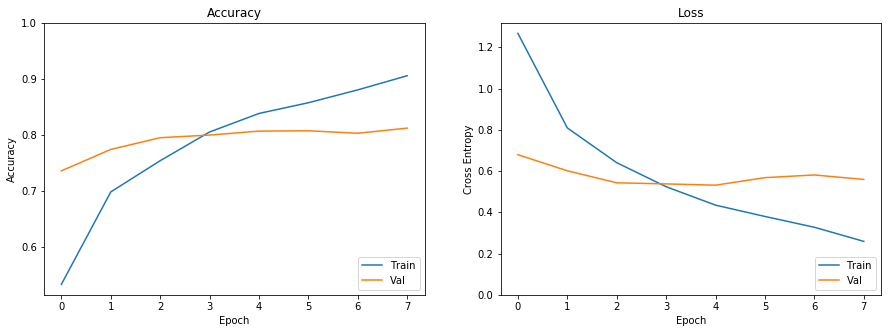

In [16]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()), 1])
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.title('Loss')
plt.show();

In [17]:
print('Confusion Matrix ...')
cm = confusion_matrix(test['label'][:top].tolist(), y_pred)
df = pd.DataFrame(cm)
df.to_csv('csv/' + model_name + 'Hair' + '_cm.csv')
print(df)

Confusion Matrix ...
     0    1    2    3    4
0  774   17    1    5  100
1   16  717    3  146    8
2    2    1  768   92   35
3    4  124   97  649   23
4  181   22   85   30  580


In [ ]:
# def classification_report(y_test, y_pred):
#     print('Classification Report ...')
#     cr = classification_report(y_test, y_pred, output_dict=True)
#     df = pd.DataFrame(cr)
#     df.to_csv('csv/' + model_name + 'Hair' + '_cr.csv')
#     print(cr)

In [19]:
classification_report(test['label'][:top].tolist(), y_pred)

'              precision    recall  f1-score   support\n\n        Bald       0.79      0.86      0.83       897\n  Black_Hair       0.81      0.81      0.81       890\n  Blond_Hair       0.81      0.86      0.83       898\n  Brown_Hair       0.70      0.72      0.71       897\n   Gray_Hair       0.78      0.65      0.71       898\n\n    accuracy                           0.78      4480\n   macro avg       0.78      0.78      0.78      4480\nweighted avg       0.78      0.78      0.78      4480\n'